<a href="https://colab.research.google.com/github/krishna2332002/Mini-Project/blob/main/FgsmKrishna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

import numpy as np

import matplotlib
matplotlib.use('Agg')           # noqa: E402
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

import time

In [2]:
def fgm(model, x, eps=0.01, epochs=1, sign=True, clip_min=0., clip_max=1.):
    """
    Fast gradient method.
    See https://arxiv.org/abs/1412.6572 and https://arxiv.org/abs/1607.02533
    for details.  This implements the revised version since the original FGM
    has label leaking problem (https://arxiv.org/abs/1611.01236).
    :param model: A wrapper that returns the output as well as logits.
    :param x: The input placeholder.
    :param eps: The scale factor for noise.
    :param epochs: The maximum epoch to run.
    :param sign: Use gradient sign if True, otherwise use gradient value.
    :param clip_min: The minimum value in output.
    :param clip_max: The maximum value in output.
    :return: A tensor, contains adversarial samples for each input.
    """
    xadv = tf.identity(x)

    ybar = model(xadv)
    yshape = ybar.get_shape().as_list()
    ydim = yshape[1]

    indices = tf.argmax(ybar, axis=1)
    target = tf.cond(
        tf.equal(ydim, 1),
        lambda: tf.nn.relu(tf.sign(ybar - 0.5)),
        lambda: tf.one_hot(indices, ydim, on_value=1.0, off_value=0.0))

    if 1 == ydim:
        loss_fn = tf.nn.sigmoid_cross_entropy_with_logits
    else:
        loss_fn = tf.nn.softmax_cross_entropy_with_logits

    if sign:
        noise_fn = tf.sign
    else:
        noise_fn = tf.identity

    eps = tf.abs(eps)

    def _cond(xadv, i):
        return tf.less(i, epochs)

    def _body(xadv, i):
        ybar, logits = model(xadv, logits=True)
        loss = loss_fn(labels=target, logits=logits)
        dy_dx, = tf.gradients(loss, xadv)
        xadv = tf.stop_gradient(xadv + eps*noise_fn(dy_dx))
        xadv = tf.clip_by_value(xadv, clip_min, clip_max)
        return xadv, i+1

    xadv, _ = tf.while_loop(_cond, _body, (xadv, 0), back_prop=False,
                            name='fast_gradient')
    return xadv
def fgmt(model, x, y=None, eps=0.01, epochs=1, sign=True, clip_min=0.,
         clip_max=1.):
    """
    Fast gradient method with target
    See https://arxiv.org/pdf/1607.02533.pdf.  This method is different from
    FGM that instead of decreasing the probability for the correct label, it
    increases the probability for the desired label.
    :param model: A model that returns the output as well as logits.
    :param x: The input placeholder.
    :param y: The desired target label, set to the least-likely class if None.
    :param eps: The noise scale factor.
    :param epochs: Maximum epoch to run.
    :param sign: Use gradient sign if True, otherwise gradient values.
    :param clip_min: Minimum value in output.
    :param clip_max: Maximum value in output.
    """
    xadv = tf.identity(x)

    ybar = model(xadv)
    ydim = ybar.get_shape().as_list()[1]
    n = tf.shape(ybar)[0]

    if y is None:
        indices = tf.argmin(ybar, axis=1)
    else:
        indices = tf.cond(tf.equal(0, tf.rank(y)),
                          lambda: tf.zeros([n], dtype=tf.int32) + y,
                          lambda: tf.zeros([n], dtype=tf.int32))
    target = tf.cond(
        tf.equal(ydim, 1),
        lambda: 1 - ybar,
        lambda: tf.one_hot(indices, ydim, on_value=1.0, off_value=0.0))

    if 1 == ydim:
        loss_fn = tf.nn.sigmoid_cross_entropy_with_logits
    else:
        loss_fn = tf.nn.softmax_cross_entropy_with_logits

    if sign:
        noise_fn = tf.sign
    else:
        noise_fn = tf.identity

    eps = -tf.abs(eps)

    def _cond(xadv, i):
        return tf.less(i, epochs)

    def _body(xadv, i):
        ybar, logits = model(xadv, logits=True)
        loss = loss_fn(labels=target, logits=logits)
        dy_dx, = tf.gradients(loss, xadv)
        xadv = tf.stop_gradient(xadv + eps*noise_fn(dy_dx))
        xadv = tf.clip_by_value(xadv, clip_min, clip_max)
        return xadv, i+1

    xadv, _ = tf.while_loop(_cond, _body, (xadv, 0), back_prop=False,
                            name='fast_gradient_target')
    return xadv

In [3]:
img_size = 28
img_chan = 1
n_classes = 10
maxTime = 0

In [4]:
print('\nLoading MNIST')

mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = np.reshape(X_train, [-1, img_size, img_size, img_chan])
X_train = X_train.astype(np.float32) / 255
X_test = np.reshape(X_test, [-1, img_size, img_size, img_chan])
X_test = X_test.astype(np.float32) / 255

to_categorical = tf.keras.utils.to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


Loading MNIST
11490434/11490434 [==============================] - 0s 0us/step


In [5]:
print('\nSpliting data')

ind = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train[ind], y_train[ind]

VALIDATION_SPLIT = 0.1
n = int(X_train.shape[0] * (1-VALIDATION_SPLIT))
X_valid = X_train[n:]
X_train = X_train[:n]
y_valid = y_train[n:]
y_train = y_train[:n]

print('\nConstruction graph')


Spliting data

Construction graph


In [7]:
def model(x, logits=False, training=False):
    with tf.variable_scope('conv0'):
        z = tf.layers.conv2d(x, filters=32, kernel_size=[3, 3],
                             padding='same', activation=tf.nn.relu)
        z = tf.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)

    with tf.variable_scope('conv1'):
        z = tf.layers.conv2d(z, filters=64, kernel_size=[3, 3],
                             padding='same', activation=tf.nn.relu)
        z = tf.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)

    with tf.variable_scope('flatten'):
        shape = z.get_shape().as_list()
        z = tf.reshape(z, [-1, np.prod(shape[1:])])

    with tf.variable_scope('mlp'):
        z = tf.layers.dense(z, units=128, activation=tf.nn.relu)
        z = tf.layers.dropout(z, rate=0.25, training=training)

    logits_ = tf.layers.dense(z, units=10, name='logits')
    y = tf.nn.softmax(logits_, name='ybar')

    if logits:
        return y, logits_
    return y

In [8]:
class Dummy:
    pass


env = Dummy()

In [9]:
with tf.variable_scope('model'):
    env.x = tf.placeholder(tf.float32, (None, img_size, img_size, img_chan),
                           name='x')
    env.y = tf.placeholder(tf.float32, (None, n_classes), name='y')
    env.training = tf.placeholder_with_default(False, (), name='mode')

    env.ybar, logits = model(env.x, logits=True, training=env.training)

    with tf.variable_scope('acc'):
        count = tf.equal(tf.argmax(env.y, axis=1), tf.argmax(env.ybar, axis=1))
        env.acc = tf.reduce_mean(tf.cast(count, tf.float32), name='acc')

    with tf.variable_scope('loss'):
        xent = tf.nn.softmax_cross_entropy_with_logits(labels=env.y,
                                                       logits=logits)
        env.loss = tf.reduce_mean(xent, name='loss')

    with tf.variable_scope('train_op'):
        optimizer = tf.train.AdamOptimizer()
        env.train_op = optimizer.minimize(env.loss)

    env.saver = tf.train.Saver()

with tf.variable_scope('model', reuse=True):
    env.fgsm_eps = tf.placeholder(tf.float32, (), name='fgsm_eps')
    env.fgsm_epochs = tf.placeholder(tf.int32, (), name='fgsm_epochs')
    env.x_fgsm = fgm(model, env.x, epochs=env.fgsm_epochs, eps=env.fgsm_eps)

<ipython-input-7-05992fcfccee>:3: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  z = tf.layers.conv2d(x, filters=32, kernel_size=[3, 3],
<ipython-input-7-05992fcfccee>:5: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  z = tf.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)
<ipython-input-7-05992fcfccee>:8: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  z = tf.layers.conv2d(z, filters=64, kernel_size=[3, 3],
<ipython-input-7-05992fcfccee>:10: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  z = tf.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)
<ipython-input-7-05992fcfccee>:17: UserWarning: `tf.layers.dense` is 

In [10]:
print('\nInitializing graph')

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())


Initializing graph


In [11]:
def evaluate(sess, env, X_data, y_data, batch_size=128):
    """
    Evaluate TF model by running env.loss and env.acc.
    """
    print('\nEvaluating')

    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    loss, acc = 0, 0

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        cnt = end - start
        batch_loss, batch_acc = sess.run(
            [env.loss, env.acc],
            feed_dict={env.x: X_data[start:end],
                       env.y: y_data[start:end]})
        loss += batch_loss * cnt
        acc += batch_acc * cnt
    loss /= n_sample
    acc /= n_sample

    print(' loss: {0:.4f} acc: {1:.4f}'.format(loss, acc))
    return loss, acc

In [12]:
def train(sess, env, X_data, y_data, X_valid=None, y_valid=None, epochs=1,
          load=False, shuffle=True, batch_size=128, name='model'):
    """
    Train a TF model by running env.train_op.
    """
    if load:
        if not hasattr(env, 'saver'):
            return print('\nError: cannot find saver op')
        print('\nLoading saved model')
        return env.saver.restore(sess, 'model/{}'.format(name))

    print('\nTrain model')
    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    for epoch in range(epochs):
        print('\nEpoch {0}/{1}'.format(epoch + 1, epochs))

        if shuffle:
            print('\nShuffling data')
            ind = np.arange(n_sample)
            np.random.shuffle(ind)
            X_data = X_data[ind]
            y_data = y_data[ind]

        for batch in range(n_batch):
            print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
            start = batch * batch_size
            end = min(n_sample, start + batch_size)
            sess.run(env.train_op, feed_dict={env.x: X_data[start:end],
                                              env.y: y_data[start:end],
                                              env.training: True})
        if X_valid is not None:
            evaluate(sess, env, X_valid, y_valid)

    if hasattr(env, 'saver'):
        print('\n Saving model')
        os.makedirs('model', exist_ok=True)
        env.saver.save(sess, 'model/{}'.format(name))

In [13]:
def predict(sess, env, X_data, batch_size=128):
    """
    Do inference by running env.ybar.
    """
    print('\nPredicting')
    n_classes = env.ybar.get_shape().as_list()[1]

    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    yval = np.empty((n_sample, n_classes))

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        y_batch = sess.run(env.ybar, feed_dict={env.x: X_data[start:end]})
        yval[start:end] = y_batch
    print()
    return yval

In [14]:
def make_fgsm(sess, env, X_data, epochs=1, eps=0.01, batch_size=128):
    """
    Generate FGSM by running env.x_fgsm.
    """
    print('\nMaking adversarials via FGSM')

    n_sample = X_data.shape[0]
    n_batch = int((n_sample + batch_size - 1) / batch_size)
    X_adv = np.empty_like(X_data)

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        adv = sess.run(env.x_fgsm, feed_dict={
            env.x: X_data[start:end],
            env.fgsm_eps: eps,
            env.fgsm_epochs: epochs})
        X_adv[start:end] = adv
    print()

    return X_adv


In [15]:
print('\nTraining')
start = time.time()
train(sess, env, X_train, y_train, X_valid, y_valid, load=False, epochs=5,
      name='mnist')
print("\nTime taken to train data : ", time.time() - start, "seconds")


Training

Train model

Epoch 1/5

Shuffling data

Evaluating
 loss: 0.0761 acc: 0.9756

Epoch 2/5

Shuffling data

Evaluating
 loss: 0.0467 acc: 0.9850

Epoch 3/5

Shuffling data

Evaluating
 loss: 0.0389 acc: 0.9876

Epoch 4/5

Shuffling data

Evaluating
 loss: 0.0321 acc: 0.9898

Epoch 5/5

Shuffling data

Evaluating
 loss: 0.0352 acc: 0.9893

 Saving model

Time taken to train data :  328.57668948173523 seconds


In [16]:
print('\nEvaluating on clean data')
start = time.time()
evaluate(sess, env, X_test, y_test)
print("\nTime taken to evaluate on clean data : ", time.time() - start, "seconds")


Evaluating on clean data

Evaluating
 loss: 0.0296 acc: 0.9889

Time taken to evaluate on clean data :  4.355363845825195 seconds


In [17]:
print('\nGenerating adversarial data')
start = time.time()
X_adv = make_fgsm(sess, env, X_test, eps=0.01, epochs=12)
print("\nTime taken to generate adversarial data", time.time() - start, "seconds")


Generating adversarial data

Making adversarials via FGSM


Time taken to generate adversarial data 157.60528254508972 seconds


In [18]:
print('\nEvaluating on adversarial data')
start = time.time()
evaluate(sess, env, X_adv, y_test)
print("\nTime taken to evaluate on adversarial data", time.time() - start, "seconds")


Evaluating on adversarial data

Evaluating
 loss: 1.4117 acc: 0.5903

Time taken to evaluate on adversarial data 3.2446303367614746 seconds


In [19]:
print('\nRandomly sample adversarial data from each category')

y1 = predict(sess, env, X_test)
y2 = predict(sess, env, X_adv)

z0 = np.argmax(y_test, axis=1)
z1 = np.argmax(y1, axis=1)
z2 = np.argmax(y2, axis=1)



Randomly sample adversarial data from each category

Predicting
 batch 79/79

Predicting
 batch 79/79


In [20]:
# X_tmp = np.empty((10, 28, 28))
# y_tmp = np.empty((10, 10))
# for i in range(10):
#     print('Target {0}'.format(i))
#     ind, = np.where(np.all([z0 == i, z1 == i, z2 != i], axis=0))
#     cur = np.random.choice(ind)
#     X_org = np.squeeze(X_test[cur])
#     X_tmp[i] = np.squeeze(X_adv[cur])
#     y_tmp[i] = y2[cur]

ind = np.logical_and(z0 == z1, z1 != z2)
# print('success: ', np.sum(ind))

ind = z0 == z1

X_test = X_test[ind]
X_adv = X_adv[ind]
z1 = z1[ind]
z2 = z2[ind]
y2 = y2[ind]

ind, = np.where(z1 != z2)
cur = np.random.choice(ind, size=n_classes)
X_org = np.squeeze(X_test[cur])
X_tmp = np.squeeze(X_adv[cur])
y_tmp = y2[cur]

In [21]:
print(z1,len(z1))
print(z2,len(z2))
print(z0,len(z0))

[7 2 1 ... 4 5 6] 9889
[7 2 1 ... 4 5 6] 9889
[7 2 1 ... 4 5 6] 10000



Plotting results

Saving figure


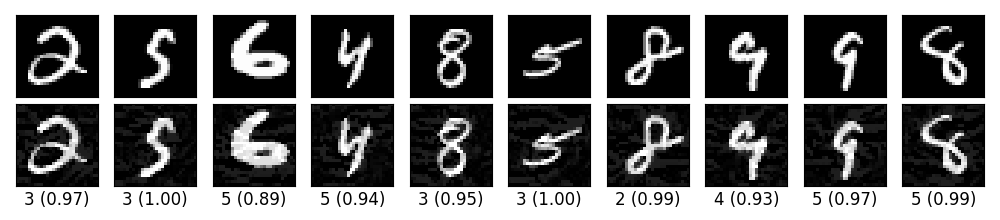

In [22]:
print('\nPlotting results')

fig = plt.figure(figsize=(10, 2.2))
gs = gridspec.GridSpec(2, 10, wspace=0.05, hspace=0.05)

label = np.argmax(y_tmp, axis=1)
proba = np.max(y_tmp, axis=1)
for i in range(10):
  ax = fig.add_subplot(gs[0, i])
  ax.imshow(X_org[i], cmap='gray', interpolation='none')
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(gs[1, i])
  ax.imshow(X_tmp[i], cmap='gray', interpolation='none')
  ax.set_xticks([])
  ax.set_yticks([])

  ax.set_xlabel('{0} ({1:.2f})'.format(label[i], proba[i]), fontsize=12)

print('\nSaving figure')

gs.tight_layout(fig)
os.makedirs('img', exist_ok=True)
plt.savefig('img/fgsm_mnist.png')

from IPython.display import Image
Image('img/fgsm_mnist.png')

In [23]:
print('Org image', len(X_org))
print('Adv image', len(X_tmp))
print('Adv image', len(X_adv))

Org image 10
Adv image 10
Adv image 9889


In [24]:
print(y2)
print(y_tmp)

[[8.94922414e-06 2.81956159e-06 2.64290084e-05 ... 4.93196994e-01
  3.35768331e-03 4.22963977e-01]
 [1.30644199e-04 2.30516642e-01 7.68513739e-01 ... 5.27491977e-07
  2.60259549e-05 2.74378654e-05]
 [7.37523224e-05 6.83094800e-01 7.71818333e-04 ... 3.44762839e-02
  1.48331909e-03 6.23695727e-04]
 ...
 [2.90350158e-06 2.82227615e-04 2.05010423e-07 ... 1.02664635e-05
  1.85910352e-02 3.28800612e-04]
 [7.19455202e-05 1.03027912e-06 2.26886004e-06 ... 4.72841947e-07
  1.12404056e-01 1.16994806e-06]
 [2.09737591e-05 3.19227802e-05 5.92529948e-04 ... 5.16831960e-06
  1.18614361e-03 2.36705655e-05]]
[[5.55415909e-07 6.30523047e-08 3.47881019e-02 9.65114474e-01
  1.89387683e-09 4.50843208e-06 9.52624424e-10 9.75071180e-06
  2.50442299e-05 5.73278485e-05]
 [2.48961101e-08 1.13363427e-07 2.67054379e-09 9.95978057e-01
  1.26882398e-08 3.95066245e-03 1.37532925e-06 2.27659935e-09
  2.26572411e-07 6.95550043e-05]
 [6.19196570e-08 7.19517004e-07 8.93555409e-07 4.18770014e-06
  1.31078480e-06 8.92015

In [25]:
print(label)
print(proba)

[3 3 5 5 3 3 2 4 5 5]
[0.96511447 0.99597806 0.89201528 0.94118851 0.95003754 0.99935454
 0.9918049  0.92703676 0.97284687 0.98573005]


In [26]:
print(y_test)
label_org = np.argmax(y_test, axis=1)
print(label_org)
print(len(label_org))

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[7 2 1 ... 4 5 6]
10000


In [27]:
import pickle

db = {}
db['x_adv'] = X_adv
db['label'] = z1
db['x_org'] = X_org
db['prob'] = proba

# Its important to use binary mode
dbfile = open('fgsm.pkl', 'ab')
      
# source, destination
pickle.dump(db, dbfile)                     
dbfile.close()